# PMIP4 Mid-Holocene

#  Introduction
This is a notebook that contains and makes some plots for a PMIP collaborative effort to get a multi-model paper describing some broad features of the mid-Holocene simulations. 

### Download data
This step will download the input data files package called PMIP4_midHolocence_cvdp_data.tar.gz, and then unpack the folders and files into data dictory.



In [ ]:
#press Enter + Shift to run coding cells
#No change needs here

! ../scripts/download_cvdp_data.sh

### Import packages and define functions

In [1]:
'''Import packages for loading data, analysing, and plotting'''

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import warnings
#warnings.filterwarnings("ignore")
#import iris
#from iris import load, Constraint
#import iris.quickplot as qplt
import xesmf as xe
%matplotlib inline
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
#from mpl_toolkits.basemap import Basemap
#from mpl_toolkits import basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import math
#import xlrd
import os
#import matplotlib.colors as colors
#from matplotlib.mlab import bivariate_normal

In [2]:
 #No change needs here

'''Define CMIP list'''


cmip6=['IPSL-CM6A-LR',
       'HadGEM3-GC31',
       'AWI-ESM']

cmip5=['GISS-E2-1-G',
     'COSMOS-ASO',
     'MRI-CGCM3',
     'CNRM-CM5',
     'FGOALS-g2',
     'GISS-E2-R',
     'EC-EARTH-2-2',
     'IPSL-CM5A-LR',
     'bcc-csm1-1',
     'HadGEM2-CC',
     'HadCM3',
     'MPI-ESM-P',
     'CCSM4',
     'CSIRO-Mk3L-1-2',
     'CSIRO-Mk3-6-0',
     'FGOALS-s2',
     'MIROC-ESM']
cmip_all=['GISS-E2-1-G',
 'COSMOS-ASO',
 'AWI-ESM',
 'MRI-CGCM3',
 'CNRM-CM5',
 'FGOALS-g2',
 'GISS-E2-R',
 'EC-EARTH-2-2',
 'IPSL-CM5A-LR',
 'IPSL-CM6A-LR',
 'bcc-csm1-1',
 'HadGEM3-GC31',
 'HadGEM2-CC',
 'HadCM3',
 'MPI-ESM-P',
 'CCSM4',
 'CSIRO-Mk3L-1-2',
 'CSIRO-Mk3-6-0',
 'FGOALS-s2',
 'MIROC-ESM']

cmip={}
cmip['CMIP5']=cmip5
cmip['CMIP6']=cmip6
cmip['CMIP']=cmip_all

In [3]:
#No change needs here

'''Define functions'''

#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "data" 
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "data/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "data/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='data/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames


def identify_ensemble_members(variable_name,experiment_name):
    datadir="data/%s" %(experiment_name)
    ensemble_members=!scripts/find_experiment_ensemble_members.bash {experiment_name} {variable_name} {datadir}
    return ensemble_members

def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict
    
def ensemble_mean(cmip_v):
    n=0
    average=0
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-90., 90., 1.0)),
                         'lon': (['lon'], np.arange(0., 360., 1.0))})
    gcm_dict=ensemble_members_dict(variable_name,experiment_name)
    for gcm in gcm_dict:
        if gcm in cmip[cmip_v]:
            this_file=xr.open_dataset(gcm_dict.get(gcm),decode_times=False)
            this_var=this_file[variable_name]
            this_regridder=xe.Regridder(this_file,grid_1x1,'bilinear', reuse_weights=True) 
            var_1x1=this_regridder(this_var)
            average=(n*average+var_1x1)/(n+1)
            n=n+1
    return average


def ensemble_mean_diffence(cmip_v):
    n=0
    average=0
    A_dict=ensemble_members_dict(variable_name,experiment_name)
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-90., 90., 1.0)),
                         'lon': (['lon'], np.arange(0., 360., 1.0))})
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in cmip[cmip_v]:
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_a=expt_a_file[variable_name]
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                expt_b=expt_b_file[variable_name]
                diff=expt_a-expt_b
                this_regridder=xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=True) 
                diff_1x1=this_regridder(diff)
                average=(n*average+diff_1x1)/(n+1)
                n=n+1
    return average

#  Analysing and plotting

## 1. Single plot (CMIP6)

 ### Choosing experiment and variable

In [ ]:
experiment_name='midHolocene'
variable_name='tas_spatialmean_ann'
cmip_v='CMIP6'

 ### Calculating ensemble mean and ensemble mean difference (Experiment - piControl)

In [5]:

ensemble_average=ensemble_mean(cmip_v)
ensemble_diff=ensemble_mean_diffence(cmip_v)



Reuse existing file: bilinear_96x192_180x360.nc
Reuse existing file: bilinear_144x192_180x360.nc
Reuse existing file: bilinear_143x144_180x360.nc
Reuse existing file: bilinear_96x192_180x360.nc
Reuse existing file: bilinear_144x192_180x360.nc
Reuse existing file: bilinear_143x144_180x360.nc


### Plotting

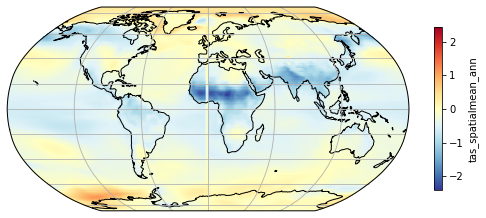

In [9]:
cmap=plt.get_cmap('RdYlBu_r')
fig = plt.figure(figsize=(9,6))
#title= '%s ensemble mean of changes in %s (%s - piControl)' %(cmip_v,variable_name,experiment_name)

ax = plt.axes(projection=ccrs.Robinson())
#ax.set_title(title)
ax.coastlines()
ax.gridlines()
ensemble_diff.plot(ax=ax, transform=ccrs.PlateCarree(),cbar_kwargs={'shrink': 0.5},cmap=cmap)

## 2. Multi plots (CMIP6, CMIP5, CMIP6-CMIP5)

In [14]:
experiment_name='midHolocene'
variable_name='tas_spatialmean_ann'
cmip_v5='CMIP5'
cmip_v6='CMIP6'

ensemble_average_v5=ensemble_mean(cmip_v5)
ensemble_diff_v5=ensemble_mean_diffence(cmip_v5)
ensemble_average_v6=ensemble_mean(cmip_v6)
ensemble_diff_v6=ensemble_mean_diffence(cmip_v6)

ensemble_diff_v=ensemble_diff_v6-ensemble_diff_v5



Reuse existing file: bilinear_192x288_180x360.nc
Reuse existing file: bilinear_128x256_180x360.nc
Reuse existing file: bilinear_96x192_180x360.nc
Reuse existing file: bilinear_56x64_180x360.nc
Reuse existing file: bilinear_160x320_180x360.nc
Reuse existing file: bilinear_60x128_180x360.nc
Reuse existing file: bilinear_108x128_180x360.nc
Reuse existing file: bilinear_90x144_180x360.nc
Reuse existing file: bilinear_145x192_180x360.nc
Reuse existing file: bilinear_96x96_180x360.nc
Reuse existing file: bilinear_64x128_180x360.nc
Reuse existing file: bilinear_96x192_180x360.nc
Reuse existing file: bilinear_160x320_180x360.nc
Reuse existing file: bilinear_64x128_180x360.nc
Reuse existing file: bilinear_192x288_180x360.nc
Reuse existing file: bilinear_128x256_180x360.nc
Reuse existing file: bilinear_96x192_180x360.nc
Reuse existing file: bilinear_56x64_180x360.nc
Reuse existing file: bilinear_160x320_180x360.nc
Reuse existing file: bilinear_60x128_180x360.nc
Reuse existing file: bilinear_108x

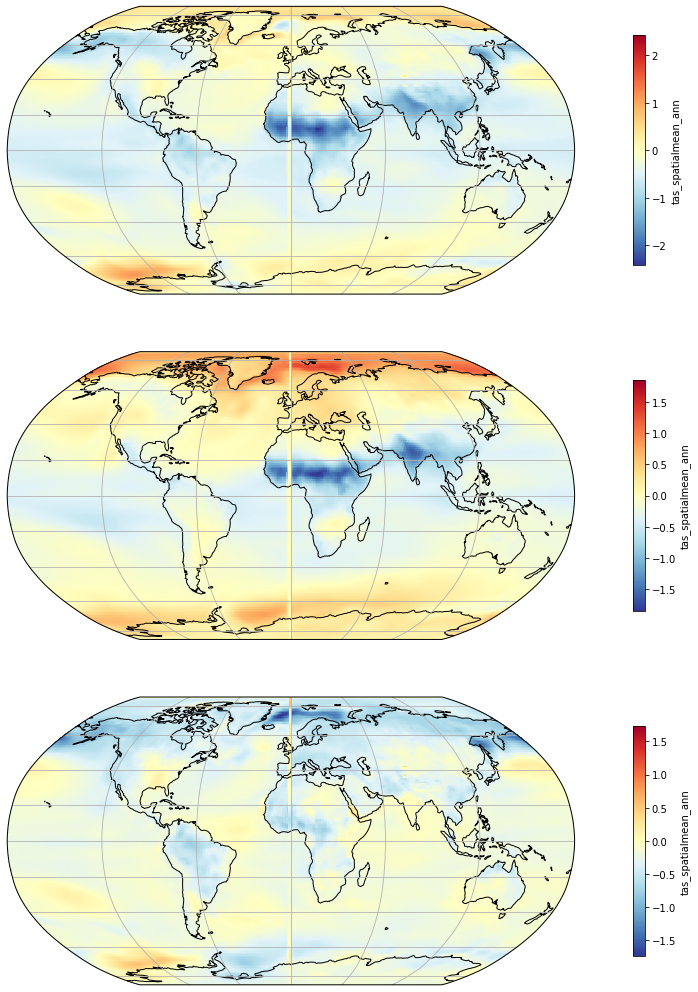

In [18]:
cmap=plt.get_cmap('RdYlBu_r')
projection = ccrs.Robinson()
plt.figure(figsize=(21, 18))
ax1 = plt.subplot(311, projection=projection)
ax1.coastlines()
ax1.gridlines()
ensemble_diff_v6.plot(ax=ax1, transform=ccrs.PlateCarree(),cbar_kwargs={'shrink': 0.8},cmap=cmap)

ax2 = plt.subplot(312, projection=projection)
ax2.coastlines()
ax2.gridlines()
ensemble_diff_v5.plot(ax=ax2, transform=ccrs.PlateCarree(),cbar_kwargs={'shrink': 0.8},cmap=cmap)

ax3 = plt.subplot(313, projection=projection)
ax3.coastlines()
ax3.gridlines()
ensemble_diff_v.plot(ax=ax3, transform=ccrs.PlateCarree(),cbar_kwargs={'shrink': 0.8},cmap=cmap)
plt.show()